## Advanced Machine Learning Models
### Goal: Achieve strong performance
### Models
 - Random Forest
 - XGBoost
 - LightGBM (primary model)
 - CatBoost
### Techniques
 - Time-series cross-validation
 - Feature importance
 - Hyperparameter tuning (Optuna)
### Output: Best ML model


# Notebook Setup & Data Preparation

 - Load feature-engineered dataset
 - Memory optimization (critical for Colab)
 - Final NaN handling (lag-safe)
### Goal:
 - target (sales_log)
 - feature list
 - Time-based train/validation split

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git

Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 147 (delta 80), reused 25 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 21.84 MiB | 12.14 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Filtering content: 100% (11/11), 315.52 MiB | 27.94 MiB/s, done.
Encountered 1 file(s) that should have been pointers, but weren't:
	data/reports/baseline_results.csv


In [2]:
# Environment Setup - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error

import os
from pathlib import Path
import gc

In [3]:
# Set Project Root
os.chdir("/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform")
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [4]:
# Load Feature-Engineered Data
DATA_DIR = Path("data/features")

train = pd.read_parquet(DATA_DIR / "train_features.parquet")

In [5]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()

0

In [6]:
# Data Handling and Sorting
train['date'] = pd.to_datetime(train['date'])
train = train.sort_values(
    ['store_nbr', 'family', 'date']
).reset_index(drop=True)

In [7]:
# Drop NaN values in Lag/Roll Features
# identify Lag/Roll Columns
lag_cols = [col for col in train.columns if "lag" in col or "roll" in col]

# Drop NaN
initial_rows = len(train)

train = train.dropna(subset=lag_cols)

print(f"Rows dropped: {initial_rows - len(train)}")
print(f"Remaining Rows: {len(train)}")
print(f"Loose Percentage: {100 * (initial_rows - len(train)) / initial_rows:.2f}")

Rows dropped: 49896
Remaining Rows: 3004452
Loose Percentage: 1.63


In [8]:
# Define Target and Features
TARGET = 'sales_log'
y = train[TARGET]

In [9]:
# Features Selection
# Drop unnecessaary Columns
Drop_cols = ['id', 'date', 'sales', 'sales_log']

FEATURES = [col for col in train.columns if col not in Drop_cols]

X = train[FEATURES]

In [10]:
# Categorical Features
CAT_COLS = train.select_dtypes(include='category').columns.tolist()
CAT_COLS

['family',
 'city',
 'state',
 'store_type',
 'holiday_type',
 'locale',
 'locale_name',
 'description']

In [11]:
# Time Based Train / Validation Split
TRAIN_END_DATE = pd.to_datetime('2017-07-15')

train_model = train.copy()
train_mask = train_model['date'] <= TRAIN_END_DATE
valid_mask = train_model['date'] > TRAIN_END_DATE

X_train = X[train_mask]
y_train = y[train_mask]

X_valid = X[valid_mask]
y_valid = y[valid_mask]

In [12]:
# Data Split Summary
train_valid = train_model[valid_mask].reset_index(drop=True)

print("DATA SPLIT SUMMARY:\n")
print(f"Train dates: {train_model[train_mask]['date'].min().date()} to {train_model[train_mask]['date'].max().date()}")
print(f"Validation dates: {train_model[valid_mask]['date'].min().date()} to {train_model[valid_mask]['date'].max().date()}")

print(f"\nTrain Shape: {X_train.shape}")
print(f"Validation Shape: {X_valid.shape}")

DATA SPLIT SUMMARY:

Train dates: 2013-01-29 to 2017-07-15
Validation dates: 2017-07-16 to 2017-08-15

Train Shape: (2949210, 58)
Validation Shape: (55242, 58)


In [13]:
# RMSLE Evaluation Function
def rmsle(y_true, y_pred):
  y_true = np.expm1(y_true)
  y_pred = np.expm1(y_pred)
  y_pred = np.maximum(y_pred, 0)
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Model 1. Random Forest Model
 - Captures non-linearity
 - Strong improvement over linear models
 - Gives feature importance intuition

In [14]:
# Import Libraries
!pip install category_encoders

from sklearn.ensemble import RandomForestRegressor
from category_encoders import TargetEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 8.6 MB/s eta 0:00:00


In [15]:
# Handling Categorical Features

te = TargetEncoder()
X_train_te = te.fit_transform(X_train, y_train)
X_valid_te = te.transform(X_valid)


In [16]:
# Define RF Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

In [17]:
# Train RF Model
rf_model.fit(X_train_te, y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=50, n_jobs=-1, random_state=42)

In [18]:
# Validation Prediction
rf_valid_pred = rf_model.predict(X_valid_te)
rf_rmsle = rmsle(y_valid, rf_valid_pred)
print(f"Random Forest RMSLE: {rf_rmsle:.4f}")

Random Forest RMSLE: 0.3985


In [19]:
# feature Importances
# Create Importance Dataframe
rf_importance = pd.DataFrame({
    'feature': X_train_te.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Sort by Importance
rf_importance = rf_importance.sort_values(by='importance', ascending=False)

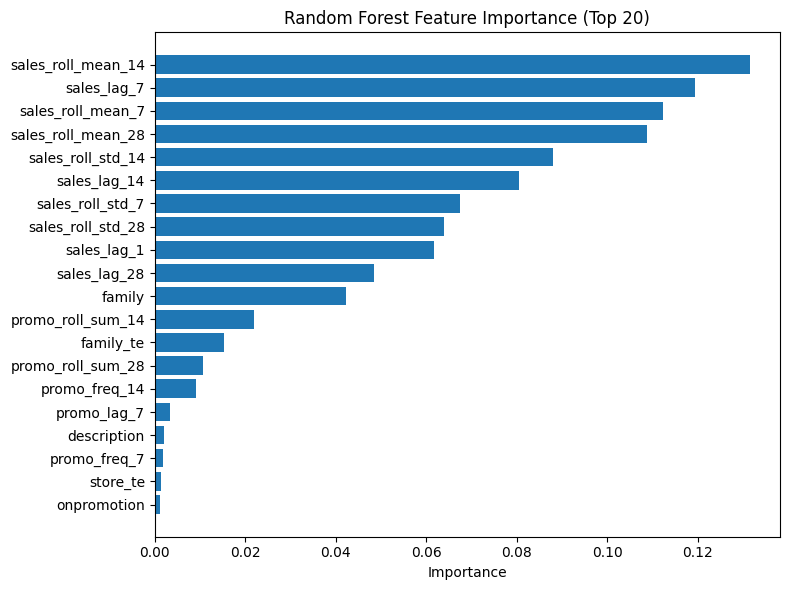

In [20]:
plt.figure(figsize=(8, 6))
plt.barh(
    rf_importance["feature"][:20][::-1],
    rf_importance["importance"][:20][::-1]
)
plt.title("Random Forest Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [21]:
# Save Feature Importances
rf_importance.to_csv("rf_feature_importance.csv", index=False)

In [22]:
# Save Target Encoder
import joblib
joblib.dump(te, "models/target_encoder.pkl")

# Save Random Forest Model
joblib.dump(rf_model, "models/random_forest.pkl")

['models/random_forest.pkl']

## Model 2. XGBoost
 -  Industry-standard GBM
 -  Excellent with lag + sparse features
 -  Strong bias–variance tradeoff
 -  Much faster & better than Random Forest

In [23]:
# Import Library
!pip install -q xgboost

import xgboost as xgb

In [24]:
# Prepare XGBoost Dataset
dtrain = xgb.DMatrix(X_train_te, label=y_train)
dvalid = xgb.DMatrix(X_valid_te, label=y_valid)

In [25]:
# Define XGB Parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",   # fast & memory efficient
    "seed": 42
}

In [26]:
evals = [(dtrain, "train"), (dvalid, "valid")]

xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)


[0]	train-rmse:2.56530	valid-rmse:2.49568
[50]	train-rmse:0.45860	valid-rmse:0.43764
[100]	train-rmse:0.39145	valid-rmse:0.38824
[150]	train-rmse:0.37987	valid-rmse:0.38444
[200]	train-rmse:0.37406	valid-rmse:0.38356
[250]	train-rmse:0.36924	valid-rmse:0.38272
[300]	train-rmse:0.36527	valid-rmse:0.38202
[350]	train-rmse:0.36219	valid-rmse:0.38126
[400]	train-rmse:0.35929	valid-rmse:0.38126
[420]	train-rmse:0.35839	valid-rmse:0.38149


In [27]:
# Validation prediction
xgb_valid_pred = xgb_model.predict(dvalid)
xgb_rmsle = rmsle(y_valid, xgb_valid_pred)
print(f"XGBoost RMSLE: {xgb_rmsle:.4f}")

XGBoost RMSLE: 0.3815


In [28]:
# Overfitting Check - Train vs Valid
xgb_train_pred = xgb_model.predict(dtrain)
train_rmsle = rmsle(y_train, xgb_train_pred)
valid_rmsle = xgb_rmsle

print(f"Train RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {valid_rmsle:.4f}")

Train RMSLE: 0.3582
Validation RMSLE: 0.3815


In [29]:
# Feature Importance - Top 20
importances = xgb_model.get_score(importance_type="weight")

xgb_importance = pd.DataFrame({
    "feature": list(importances.keys()),
    "importance": list(importances.values())
}).sort_values(by="importance", ascending=False)

xgb_importance = xgb_importance.reset_index(drop=True)

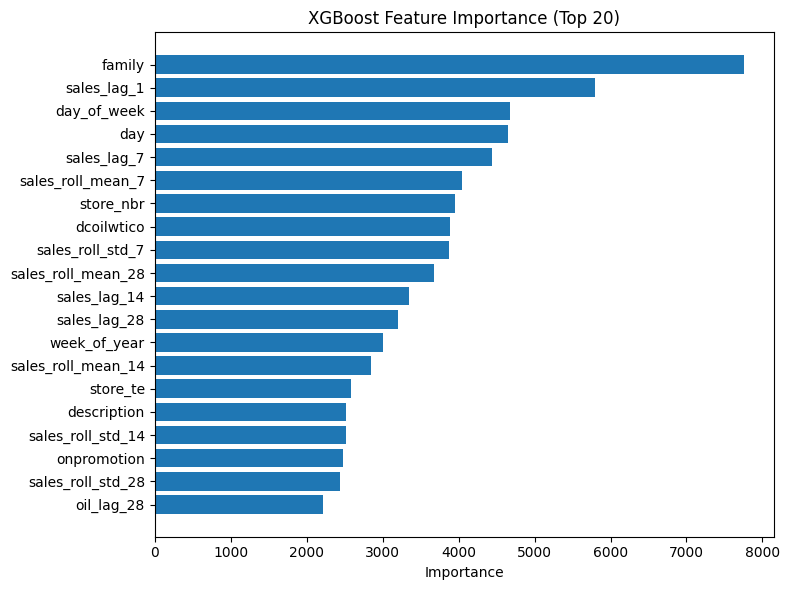

In [30]:
plt.figure(figsize=(8, 6))
plt.barh(
    xgb_importance["feature"][:20][::-1],
    xgb_importance["importance"][:20][::-1]
)
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [31]:
# Save Feature Importances
xgb_importance.to_csv("xgb_feature_importance.csv", index=False)

In [32]:
# Save XGBoost
xgb_model.save_model("models/xgboost.json")

## Model 3 - LightGBM (PRIMARY MODEL)
-  Built for large tabular time-series
-  Extremely fast
-  Handles non-linearity + interactions
-  Kaggle favorite for this dataset
-  Best balance of accuracy + speed

In [33]:
# import Library
!pip install -q lightgbm

import lightgbm as lgb

In [34]:
# Prepare LightGBM Dataset
lgb_train = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)
lgb_valid = lgb.Dataset(
    X_valid,
    label=y_valid,
    reference=lgb_train,
    categorical_feature=CAT_COLS,
    free_raw_data=False
)

In [35]:
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq":5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "verbosity": -1,
    "boosting_type": "gbdt"
}

In [36]:
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=["train", "valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[996]	train's rmse: 0.346272	valid's rmse: 0.377392


In [37]:
# Validation Prediction
lgb_valid_pred = lgb_model.predict(
    X_valid,
    num_iteration=lgb_model.best_iteration
)
lgb_rmsle = rmsle(y_valid, lgb_valid_pred)
print(f"LightGBM RMSLE: {lgb_rmsle:.4f}")

LightGBM RMSLE: 0.3774


In [38]:
# Feature Importance
lgb_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": lgb_model.feature_importance()
}).sort_values(by="importance", ascending=False)

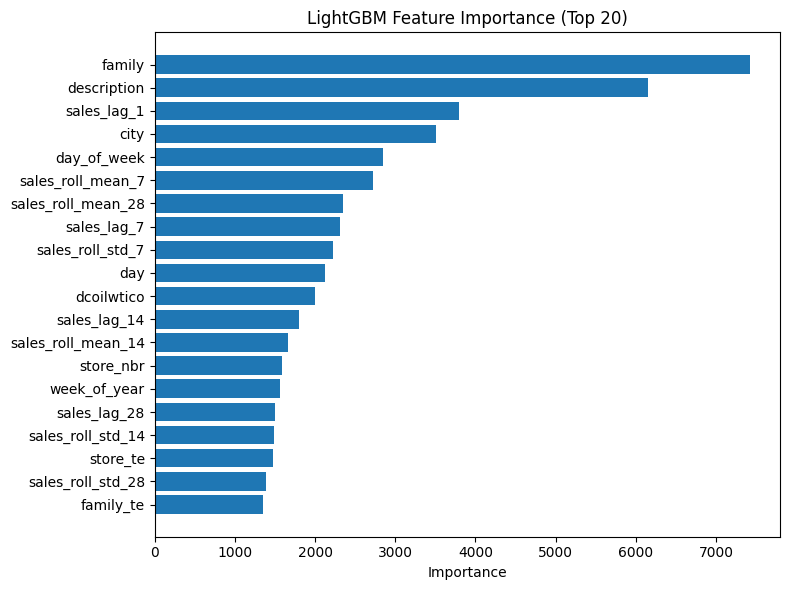

In [39]:
# Plot top 20 Features
plt.figure(figsize=(8, 6))
plt.barh(
    lgb_importance["feature"][:20][::-1],
    lgb_importance["importance"][:20][::-1]
)
plt.title("LightGBM Feature Importance (Top 20)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [40]:
# Save Feature Importance
lgb_importance.to_csv("lgb_feature_importance.csv", index=False)

In [41]:
# Save LightBGM
lgb_model.save_model("models/baseline_lightgbm.txt")

##Model 4 - CatBoost (practical view)

 - Strong with categorical features
 - Handles non-linearity well
 - Stable training, less tuning required

In [42]:
# Import Library
!pip install -q catboost

from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


In [43]:
# Define CatBoost Model
cat_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    bagging_temperature=0.2,
    verbose=100,
    early_stopping_rounds=50
)

In [44]:
cat_model.fit(
    X_train, y_train,
    cat_features=CAT_COLS,
    eval_set=(X_valid, y_valid),
    use_best_model=True
)

0:	learn: 2.5688269	test: 2.4986272	best: 2.4986272 (0)	total: 9.95s	remaining: 49m 35s
100:	learn: 0.4260240	test: 0.4039371	best: 0.4039371 (100)	total: 11m 28s	remaining: 22m 36s
200:	learn: 0.4045186	test: 0.3960413	best: 0.3960413 (200)	total: 22m 44s	remaining: 11m 12s
299:	learn: 0.3937329	test: 0.3921242	best: 0.3921242 (299)	total: 34m 6s	remaining: 0us

bestTest = 0.3921242145
bestIteration = 299



In [45]:
# Validation Prediction
cat_valid_pred = cat_model.predict(X_valid)
cat_rmsle = rmsle(y_valid, cat_valid_pred)

print(f"CatBoost RMSLE: {cat_rmsle:.4f}")

CatBoost RMSLE: 0.3921


In [46]:
# Overfitting Check
cat_train_pred = cat_model.predict(X_train)
train_rmsle = rmsle(y_train, cat_train_pred)
valid_rmsle = cat_rmsle

print(f"Train RMSLE: {train_rmsle:.4f}")
print(f"Validation RMSLE: {valid_rmsle:.4f}")

Train RMSLE: 0.3934
Validation RMSLE: 0.3921


In [47]:
# Save CatBoost
cat_model.save_model("models/catboost.cbm", format="cbm")

## Model Comparision
Compare Model Based on RMSLE

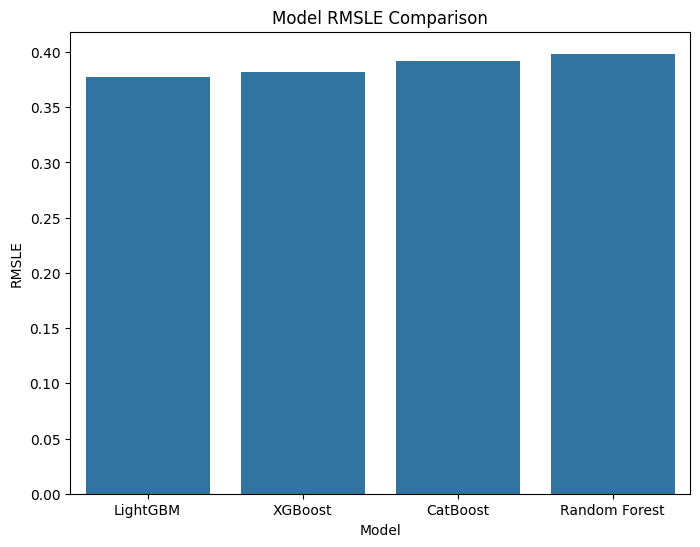

In [48]:
# Model Comparision
model_rmsle = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM", "CatBoost"],
    "RMSLE": [rf_rmsle, xgb_rmsle, lgb_rmsle, cat_rmsle]
}).sort_values(by="RMSLE", ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="RMSLE", data=model_rmsle)
plt.title("Model RMSLE Comparison")
plt.xlabel("Model")
plt.ylabel("RMSLE")
plt.show()

## Hyperparameter Tuning with Optuna (LightGBM)

### Key Principles

 - Tune only LightGBM
 - Use time-based validation
 - Optimize RMSLE
 - Keep trials controlled

In [49]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.1 MB/s eta 0:00:00


In [50]:
def objective(trial):
  params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
    "num_leaves": trial.suggest_int("num_leaves", 31, 256),
    "max_depth": trial.suggest_int("max_depth", 5, 15),
    "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
    "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
    "verbosity": -1,
    "seed": 42
  }
  model = lgb.train(
    params=params,
    train_set=lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_valid],
    callbacks=[
      lgb.early_stopping(stopping_rounds=50),
      lgb.log_evaluation(period=0)  # period=0 disables logging
    ]
  )
  preds = model.predict(
    X_valid,
    num_iteration=model.best_iteration
  )
  return rmsle(y_valid, preds)

In [ ]:
# Run Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(
  objective,
  n_trials=50,
  show_progress_bar=True
)

[I 2025-12-31 07:09:34,176] A new study created in memory with name: no-name-0de8081c-2901-4c77-a1ed-d086cbab9136


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 0.387607
[I 2025-12-31 07:12:16,604] Trial 0 finished with value: 0.3875890317114276 and parameters: {'learning_rate': 0.07445341002236604, 'num_leaves': 77, 'max_depth': 6, 'feature_fraction': 0.9068450738882254, 'bagging_fraction': 0.9839483472848439, 'bagging_freq': 4, 'lambda_l2': 2.717910691369383}. Best is trial 0 with value: 0.3875890317114276.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's rmse: 0.376642
[I 2025-12-31 07:17:59,658] Trial 1 finished with value: 0.3766192780832997 and parameters: {'learning_rate': 0.06533077482320934, 'num_leaves': 125, 'max_depth': 14, 'feature_fraction': 0.9061868693316598, 'bagging_fraction': 0.676569642134934, 'bagging_freq': 4, 'lambda_l2': 1.2343141357657812}. Best is trial 1 with value: 0.3766192780832997.
Training until validation scores don't improve for 50 

In [ ]:
# Retrain Best Parameter and score
print('Best RMSLE', study.best_value)
print('Best Parameters:')
for key, value in study.best_params.items():
  print(f'{key}: {value}')

In [ ]:
# Retrain Fine Tuned LighGBM
best_params = study.best_params
best_params.update(
    {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "seed": 42
    }
)

final_lgb_model = lgb.train(
    params=best_params,
    train_set=lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_valid],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

In [ ]:
# Final Evaluation
final_preds = final_lgb_model.predict(
    X_valid,
    num_iteration=final_lgb_model.best_iteration
)
final_rmsle = rmsle(y_valid, final_preds)

print(f"Final Tuned LightGBM RMSLE: {final_rmsle:.4f}")

In [ ]:
# Save LightBGM
final_lgb_model.save_model("models/tuned_lightgbm.txt")

## Compare all Models

In [ ]:
# Compare all Modles
final_results = pd.DataFrame({
    "Model": [
        "Random Forest",
        "XGBoost",
        "CatBoost",
        "LightGBM (Baseline)",
        "LightGBM (Tuned)"
    ],
    "RMSLE": [
        rf_rmsle,
        xgb_rmsle,
        cat_rmsle,
        lgb_rmsle,
        final_rmsle
    ]
}).sort_values("RMSLE")

final_results


# Save Final Report

In [ ]:
# Final Models Report
final_results.to_csv(
    "data/reports/ml_model_comparison_reports.csv",
    index=False
)


In [ ]:
from google.colab import files
import joblib
import os

# Create directories if they don't exist
os.makedirs("models", exist_ok=True)
os.makedirs("data/reports", exist_ok=True)

# List to track all saved files
saved_files = []

# Save Feature Importances
print("Saving feature importances...")
rf_importance.to_csv("rf_feature_importance.csv", index=False)
saved_files.append("rf_feature_importance.csv")

xgb_importance.to_csv("xgb_feature_importance.csv", index=False)
saved_files.append("xgb_feature_importance.csv")

lgb_importance.to_csv("lgb_feature_importance.csv", index=False)
saved_files.append("lgb_feature_importance.csv")

# Save Models
print("Saving models...")
# Target Encoder
joblib.dump(te, "models/target_encoder.pkl")
saved_files.append("models/target_encoder.pkl")

# Random Forest
joblib.dump(rf_model, "models/random_forest.pkl")
saved_files.append("models/random_forest.pkl")

# XGBoost
xgb_model.save_model("models/xgboost.json")
saved_files.append("models/xgboost.json")

# LightGBM Baseline
lgb_model.save_model("models/baseline_lightgbm.txt")
saved_files.append("models/baseline_lightgbm.txt")

# LightGBM Tuned
final_lgb_model.save_model("models/tuned_lightgbm.txt")
saved_files.append("models/tuned_lightgbm.txt")

# CatBoost
cat_model.save_model("models/catboost.cbm", format="cbm")
saved_files.append("models/catboost.cbm")

# Final Results Report
print("Saving reports...")
final_results.to_csv("data/reports/ml_model_comparison_reports.csv", index=False)
saved_files.append("data/reports/ml_model_comparison_reports.csv")

# Download all files to local device
print("\n" + "="*50)
print("DOWNLOADING FILES TO YOUR LOCAL DEVICE")
print("="*50)

for file_path in saved_files:
    try:
        print(f"Downloading: {file_path}")
        files.download(file_path)
    except Exception as e:
        print(f"Error downloading {file_path}: {e}")

print("\n✓ All files saved and downloaded!")
print(f"Total files: {len(saved_files)}")

In [ ]:
from google.colab import drive
from google.colab import files
import os
import joblib

# Mount Google Drive (will prompt for authorization once)
drive.mount('/content/drive')

# Create backup directory in Google Drive
DRIVE_SAVE_PATH = "/content/drive/MyDrive/ML_Models_Backup/"
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/reports", exist_ok=True)

# Track all saved files
saved_files = []

print("="*60)
print("SAVING ALL MODELS AND REPORTS")
print("="*60)

# ===== SAVE FEATURE IMPORTANCES =====
print("\n1. Saving Feature Importances...")

# RF Feature Importance
rf_importance.to_csv("rf_feature_importance.csv", index=False)
rf_importance.to_csv(f"{DRIVE_SAVE_PATH}rf_feature_importance.csv", index=False)
saved_files.append("rf_feature_importance.csv")
print("   ✓ RF Feature Importance saved")

# XGBoost Feature Importance
xgb_importance.to_csv("xgb_feature_importance.csv", index=False)
xgb_importance.to_csv(f"{DRIVE_SAVE_PATH}xgb_feature_importance.csv", index=False)
saved_files.append("xgb_feature_importance.csv")
print("   ✓ XGBoost Feature Importance saved")

# LightGBM Feature Importance
lgb_importance.to_csv("lgb_feature_importance.csv", index=False)
lgb_importance.to_csv(f"{DRIVE_SAVE_PATH}lgb_feature_importance.csv", index=False)
saved_files.append("lgb_feature_importance.csv")
print("   ✓ LightGBM Feature Importance saved")

# ===== SAVE MODELS =====
print("\n2. Saving Models...")

# Target Encoder
joblib.dump(te, "models/target_encoder.pkl")
joblib.dump(te, f"{DRIVE_SAVE_PATH}target_encoder.pkl")
saved_files.append("models/target_encoder.pkl")
print("   ✓ Target Encoder saved")

# Random Forest Model
joblib.dump(rf_model, "models/random_forest.pkl")
joblib.dump(rf_model, f"{DRIVE_SAVE_PATH}random_forest.pkl")
saved_files.append("models/random_forest.pkl")
print("   ✓ Random Forest Model saved")

# XGBoost Model
xgb_model.save_model("models/xgboost.json")
xgb_model.save_model(f"{DRIVE_SAVE_PATH}xgboost.json")
saved_files.append("models/xgboost.json")
print("   ✓ XGBoost Model saved")

# LightGBM Baseline Model
lgb_model.save_model("models/baseline_lightgbm.txt")
lgb_model.save_model(f"{DRIVE_SAVE_PATH}baseline_lightgbm.txt")
saved_files.append("models/baseline_lightgbm.txt")
print("   ✓ LightGBM Baseline Model saved")

# LightGBM Tuned Model
final_lgb_model.save_model("models/tuned_lightgbm.txt")
final_lgb_model.save_model(f"{DRIVE_SAVE_PATH}tuned_lightgbm.txt")
saved_files.append("models/tuned_lightgbm.txt")
print("   ✓ LightGBM Tuned Model saved")

# CatBoost Model
cat_model.save_model("models/catboost.cbm", format="cbm")
cat_model.save_model(f"{DRIVE_SAVE_PATH}catboost.cbm", format="cbm")
saved_files.append("models/catboost.cbm")
print("   ✓ CatBoost Model saved")

# ===== SAVE REPORTS =====
print("\n3. Saving Reports...")

# Final Results Report
os.makedirs("data/reports", exist_ok=True)
final_results.to_csv("data/reports/ml_model_comparison_reports.csv", index=False)
final_results.to_csv(f"{DRIVE_SAVE_PATH}ml_model_comparison_reports.csv", index=False)
saved_files.append("data/reports/ml_model_comparison_reports.csv")
print("   ✓ ML Model Comparison Report saved")

# =====

In [ ]:
from google.colab import drive
drive.mount('/content/drive')